# Credit Risk/Ratings Prediction

## Names: The Asset Kickers ~ Nevin Arimilli, Pranav Cheruku, Rudraksh Garg, Benjamin Kanarick

In [6]:
#Import all necessary packages
import pandas as pd
import numpy as np
import warnings


from itertools import combinations
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import xgboost as xgb

warnings.filterwarnings('ignore')

#### Read in the credit ratings data from Compustat

In [7]:
credit_ratings = pd.read_csv('Credit_Ratings.csv')
credit_ratings.head()

,datadate,gvkey,splticrm,spcsrc,conm,tic
0,1/31/2017,1004,BB+,B,AAR CORP,AIR
1,1/31/2017,1045,BB-,C,AMERICAN AIRLINES GROUP INC,AAL
2,1/31/2017,1075,A-,A,PINNACLE WEST CAPITAL CORP,PNW
3,1/31/2017,1078,BBB,B,ABBOTT LABORATORIES,ABT
4,1/31/2017,1161,CCC+,B-,ADVANCED MICRO DEVICES,AMD


In [8]:
credit_ratings = credit_ratings.rename(columns={'tic': 'TICKER'})
credit_ratings.head()

,datadate,gvkey,splticrm,spcsrc,conm,TICKER
0,1/31/2017,1004,BB+,B,AAR CORP,AIR
1,1/31/2017,1045,BB-,C,AMERICAN AIRLINES GROUP INC,AAL
2,1/31/2017,1075,A-,A,PINNACLE WEST CAPITAL CORP,PNW
3,1/31/2017,1078,BBB,B,ABBOTT LABORATORIES,ABT
4,1/31/2017,1161,CCC+,B-,ADVANCED MICRO DEVICES,AMD


#### Check to see how many companies are missing a credit rating and replace with spcsrc


In [9]:
credit_ratings.splticrm.isnull().value_counts()

False    1848
True        6
Name: splticrm, dtype: int64

In [10]:
credit_ratings['splticrm'] = credit_ratings['splticrm'].fillna(credit_ratings['spcsrc'])

In [11]:
credit_ratings.splticrm.isnull().value_counts()

False    1851
True        3
Name: splticrm, dtype: int64

#### Remove any credit ratings that are missing


In [12]:
credit_ratings = credit_ratings.dropna(subset=['splticrm', "TICKER"])
credit_ratings

,datadate,gvkey,splticrm,spcsrc,conm,TICKER
0,1/31/2017,1004,BB+,B,AAR CORP,AIR
1,1/31/2017,1045,BB-,C,AMERICAN AIRLINES GROUP INC,AAL
2,1/31/2017,1075,A-,A,PINNACLE WEST CAPITAL CORP,PNW
3,1/31/2017,1078,BBB,B,ABBOTT LABORATORIES,ABT
4,1/31/2017,1161,CCC+,B-,ADVANCED MICRO DEVICES,AMD
...,...,...,...,...,...,...
1846,1/31/2017,266315,BBB-,B-,KITE REALTY GROUP TRUST,KRG
1848,1/31/2017,272705,B,NaN,ATRIUM INNOVATIONS INC,ATBIF
1850,1/31/2017,287882,BBB,NaN,ECOPETROL SA,EC
1851,1/31/2017,295786,BB+,NaN,CNH INDUSTRIAL NV,CNHI


In [13]:
credit_ratings.splticrm.isnull().value_counts()

False    1849
Name: splticrm, dtype: int64

In [14]:
credit_ratings.drop_duplicates()

,datadate,gvkey,splticrm,spcsrc,conm,TICKER
0,1/31/2017,1004,BB+,B,AAR CORP,AIR
1,1/31/2017,1045,BB-,C,AMERICAN AIRLINES GROUP INC,AAL
2,1/31/2017,1075,A-,A,PINNACLE WEST CAPITAL CORP,PNW
3,1/31/2017,1078,BBB,B,ABBOTT LABORATORIES,ABT
4,1/31/2017,1161,CCC+,B-,ADVANCED MICRO DEVICES,AMD
...,...,...,...,...,...,...
1846,1/31/2017,266315,BBB-,B-,KITE REALTY GROUP TRUST,KRG
1848,1/31/2017,272705,B,NaN,ATRIUM INNOVATIONS INC,ATBIF
1850,1/31/2017,287882,BBB,NaN,ECOPETROL SA,EC
1851,1/31/2017,295786,BB+,NaN,CNH INDUSTRIAL NV,CNHI


In [15]:
credit_ratings.isna().sum()


datadate      0
gvkey         0
splticrm      0
spcsrc      624
conm          0
TICKER        0
dtype: int64

#### Get a txt file of all gvkeys in order to get chosen metrics out of WRDS

In [16]:
#Get all gvkeys in to a list
gvkey_list = credit_ratings.gvkey.unique()

In [17]:
#Use this .txt file in order to get all necessary data in WRDS for each ticker
gvkey_file = open('gvkey.txt','w')
for i in gvkey_list:
    gvkey_file.write(str(i) + '\n')
gvkey_file.close()

In [18]:
len(gvkey_list)

1849

In [19]:
credit_ratings["datadate"].value_counts()

1/31/2017    1849
Name: datadate, dtype: int64

#### Take the gvkey_list and ran it through WRDS to get the ratios

In [20]:
fin_ratios = pd.read_csv('fin_ratios.csv')
fin_ratios.head()


,gvkey,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,cusip
0,1004,54594,05/31/2016,11/30/2016,01/31/2017,32.067,0.711,10.443,28.310,28.563,...,2.880,0.000,0.000,0.000,-0.003,1.219,NaN,.938%,AIR,00036110
1,1045,21020,12/31/2015,09/30/2016,01/31/2017,17.273,0.231,5.241,6.979,7.069,...,NaN,0.000,0.003,0.261,-0.009,5.112,NaN,.904%,AAL,02376R10
2,1075,27991,12/31/2015,09/30/2016,01/31/2017,21.671,0.944,9.278,20.111,20.216,...,NaN,0.000,0.000,0.000,-0.040,1.083,13.274,3.37%,PNW,72348410
3,1078,20482,12/31/2015,09/30/2016,01/31/2017,35.311,0.334,14.313,24.145,24.285,...,4.614,0.070,0.000,0.000,-0.046,3.460,2.802,2.54%,ABT,00282410
4,1161,61241,12/31/2015,09/30/2016,01/31/2017,-20.033,0.060,-324.810,-26.590,-26.590,...,4.032,0.236,0.000,0.000,-0.158,25.184,NaN,NaN,AMD,00790310


In [21]:
# Get non num columns
fin_ratios.select_dtypes(include="object")

,adate,qdate,public_date,divyield,TICKER,cusip
0,05/31/2016,11/30/2016,01/31/2017,.938%,AIR,00036110
1,12/31/2015,09/30/2016,01/31/2017,.904%,AAL,02376R10
2,12/31/2015,09/30/2016,01/31/2017,3.37%,PNW,72348410
3,12/31/2015,09/30/2016,01/31/2017,2.54%,ABT,00282410
4,12/31/2015,09/30/2016,01/31/2017,NaN,AMD,00790310
...,...,...,...,...,...,...
1025,12/31/2015,09/30/2016,01/31/2017,1.62%,VAC,57164Y10
1026,12/31/2015,09/30/2016,01/31/2017,NaN,ACHC,00404A10
1027,12/31/2015,09/30/2016,01/31/2017,NaN,VNTV,92210H10
1028,12/31/2015,09/30/2016,01/31/2017,NaN,MX,55933J20


<AxesSubplot:>

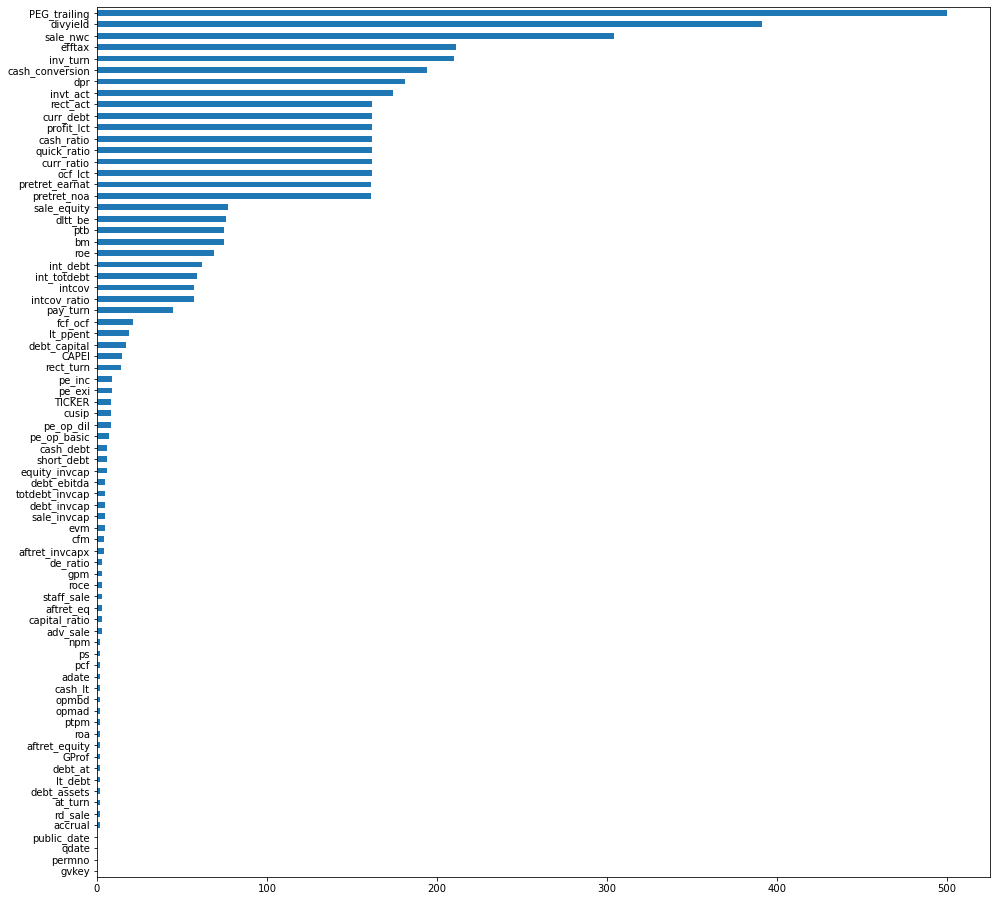

In [22]:
# Show columns that have most NaNs
fin_ratios.isna().sum().sort_values().plot(kind = 'barh', figsize=(16,16))

In [23]:
fin_ratios.shape

(1030, 76)

In [24]:
len(fin_ratios.isna().sum())

76

### Remove highly correlated of features

<AxesSubplot:>

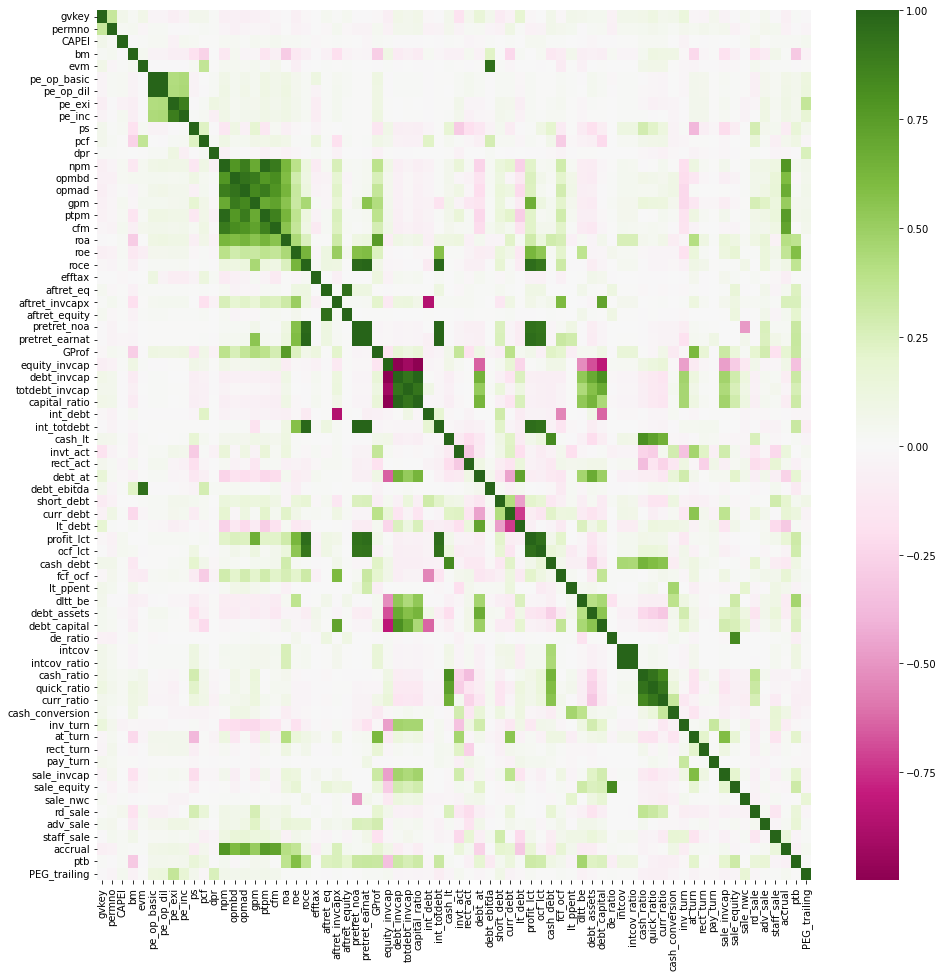

In [25]:
# Plot correlationss
fig, ax = plt.subplots(figsize=(16,16))    
corr = fin_ratios.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="PiYG")

In [26]:
# Get high correlations above 0.75
s = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).abs().unstack()
so = s.sort_values()
high_corr_cols = so[(so>.75) & (so != 1)]

In [27]:
# Remove one column from each set of high correlated features
drop_cols = [i[1]for i in high_corr_cols.index]

<AxesSubplot:>

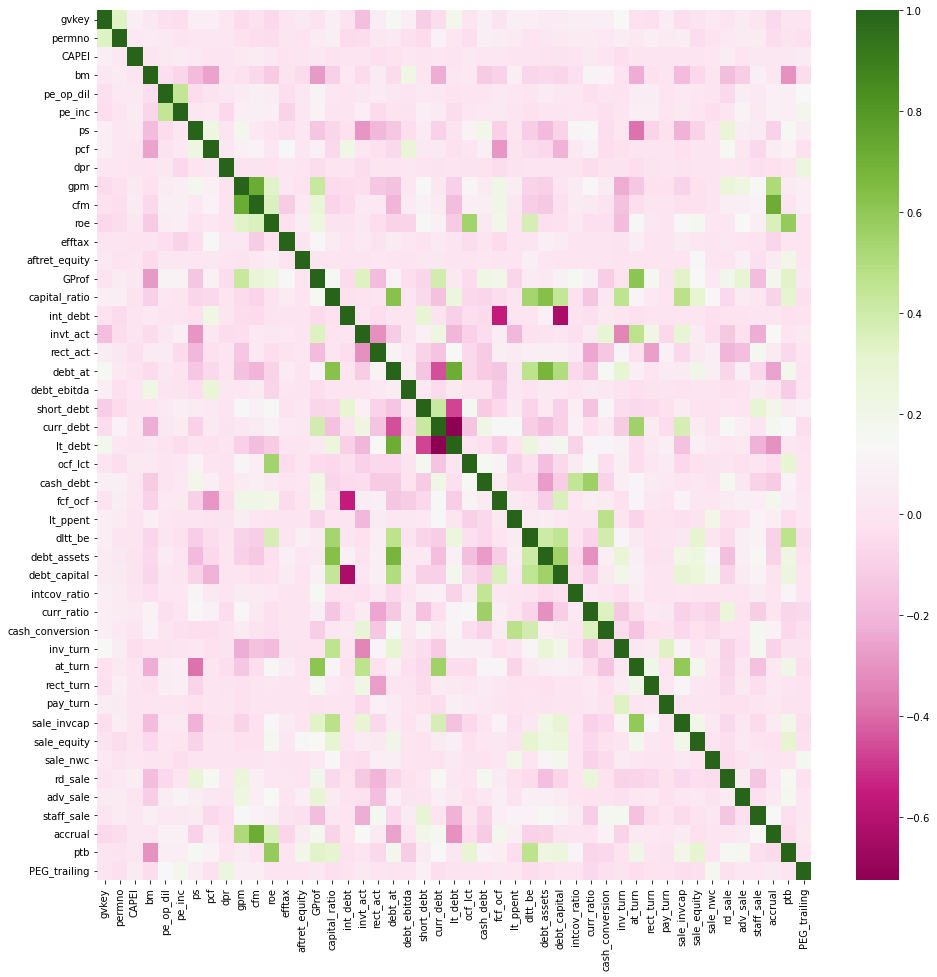

In [28]:
# Ensure high correlations are removed
non_corr = fin_ratios.drop(drop_cols, axis=1)
fig, ax = plt.subplots(figsize=(16,16))    
corr = non_corr.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="PiYG")

In [29]:
print(fin_ratios.shape)
non_corr.shape

(1030, 76)


(1030, 53)

In [30]:
s = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).abs().unstack()
so = s.sort_values()
high_corr_cols = so[(so>.75) & (so != 1)]
high_corr_cols

Series([], dtype: float64)

In [31]:
fin_ratios = non_corr.copy()

In [32]:
fin_ratios.shape

(1030, 53)

### Remove columns and rows have more than 20% missing values

In [34]:
THRESHOLD = .2
fin_ratios = fin_ratios.dropna(axis=0, thresh=int(fin_ratios.shape[1]*(1-THRESHOLD)))
fin_ratios.shape

(1011, 53)

In [35]:
THRESHOLD = .2
drop_cols = fin_ratios.isna().sum()[fin_ratios.isna().sum()/fin_ratios.shape[0] > THRESHOLD].index
drop_cols

Index(['sale_nwc', 'PEG_trailing', 'divyield'], dtype='object')

In [36]:
fin_ratios = fin_ratios.drop(drop_cols, axis = 1)

In [37]:
fin_ratios.shape

(1011, 50)

In [38]:
# Clean more columns out of dataframe
fin_ratios = fin_ratios.drop(["adate", "qdate", 'public_date'], axis=1)

In [39]:
fin_ratios.shape

(1011, 47)

In [40]:
# Fill with mean for any NaNs
fin_ratios = fin_ratios.fillna(fin_ratios.mean(axis=0))

In [41]:
fin_ratios

,gvkey,permno,CAPEI,bm,pe_op_dil,pe_inc,ps,pcf,dpr,gpm,...,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,TICKER,cusip
0,1004,54594,32.067,0.711000,28.563,28.820,0.680,23.465,0.251000,0.172,...,8.074,1.595,1.868000,0.000,0.000,0.000,-0.003,1.219000,AIR,00036110
1,1045,21020,17.273,0.231000,7.069,4.763,0.561,3.665,0.043000,0.371,...,14.239,1.614,8.404000,0.000,0.003,0.261,-0.009,5.112000,AAL,02376R10
2,1075,27991,21.671,0.944000,20.216,20.216,2.473,8.324,0.630000,0.381,...,7.911,0.409,0.750000,0.000,0.000,0.000,-0.040,1.083000,PNW,72348410
3,1078,20482,35.311,0.334000,24.285,45.901,3.472,25.128,1.531000,0.616,...,7.312,0.769,0.993000,0.070,0.000,0.000,-0.046,3.460000,ABT,00282410
4,1161,61241,-20.033,0.060000,-26.590,-15.029,2.351,-154.420,0.846106,0.340,...,3.703,2.448,5.076862,0.236,0.000,0.000,-0.158,25.184000,AMD,00790310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,191255,13085,61.777,0.506000,20.348,20.990,1.312,23.536,0.281000,0.391,...,11.542,1.082,1.890000,0.000,0.001,0.000,0.009,2.332000,VAC,57164Y10
1026,192255,13105,65.359,0.541000,22.179,366.667,1.278,9.292,0.000000,0.320,...,17.295,0.477,1.167000,0.000,0.000,0.543,-0.064,1.432000,ACHC,00404A10
1027,194956,13314,88.185,0.147000,40.416,46.104,2.884,14.707,0.000000,0.453,...,5.135,0.811,3.249000,0.000,0.000,0.000,-0.073,7.739000,VNTV,92210H10
1028,233491,12629,-23.075,0.625386,7.107,6.935,0.456,12.270,0.000000,0.250,...,8.257,4.196,5.076862,0.111,0.000,0.000,0.040,3.764293,MX,55933J20


In [42]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_only = fin_ratios.select_dtypes(include=numerics)

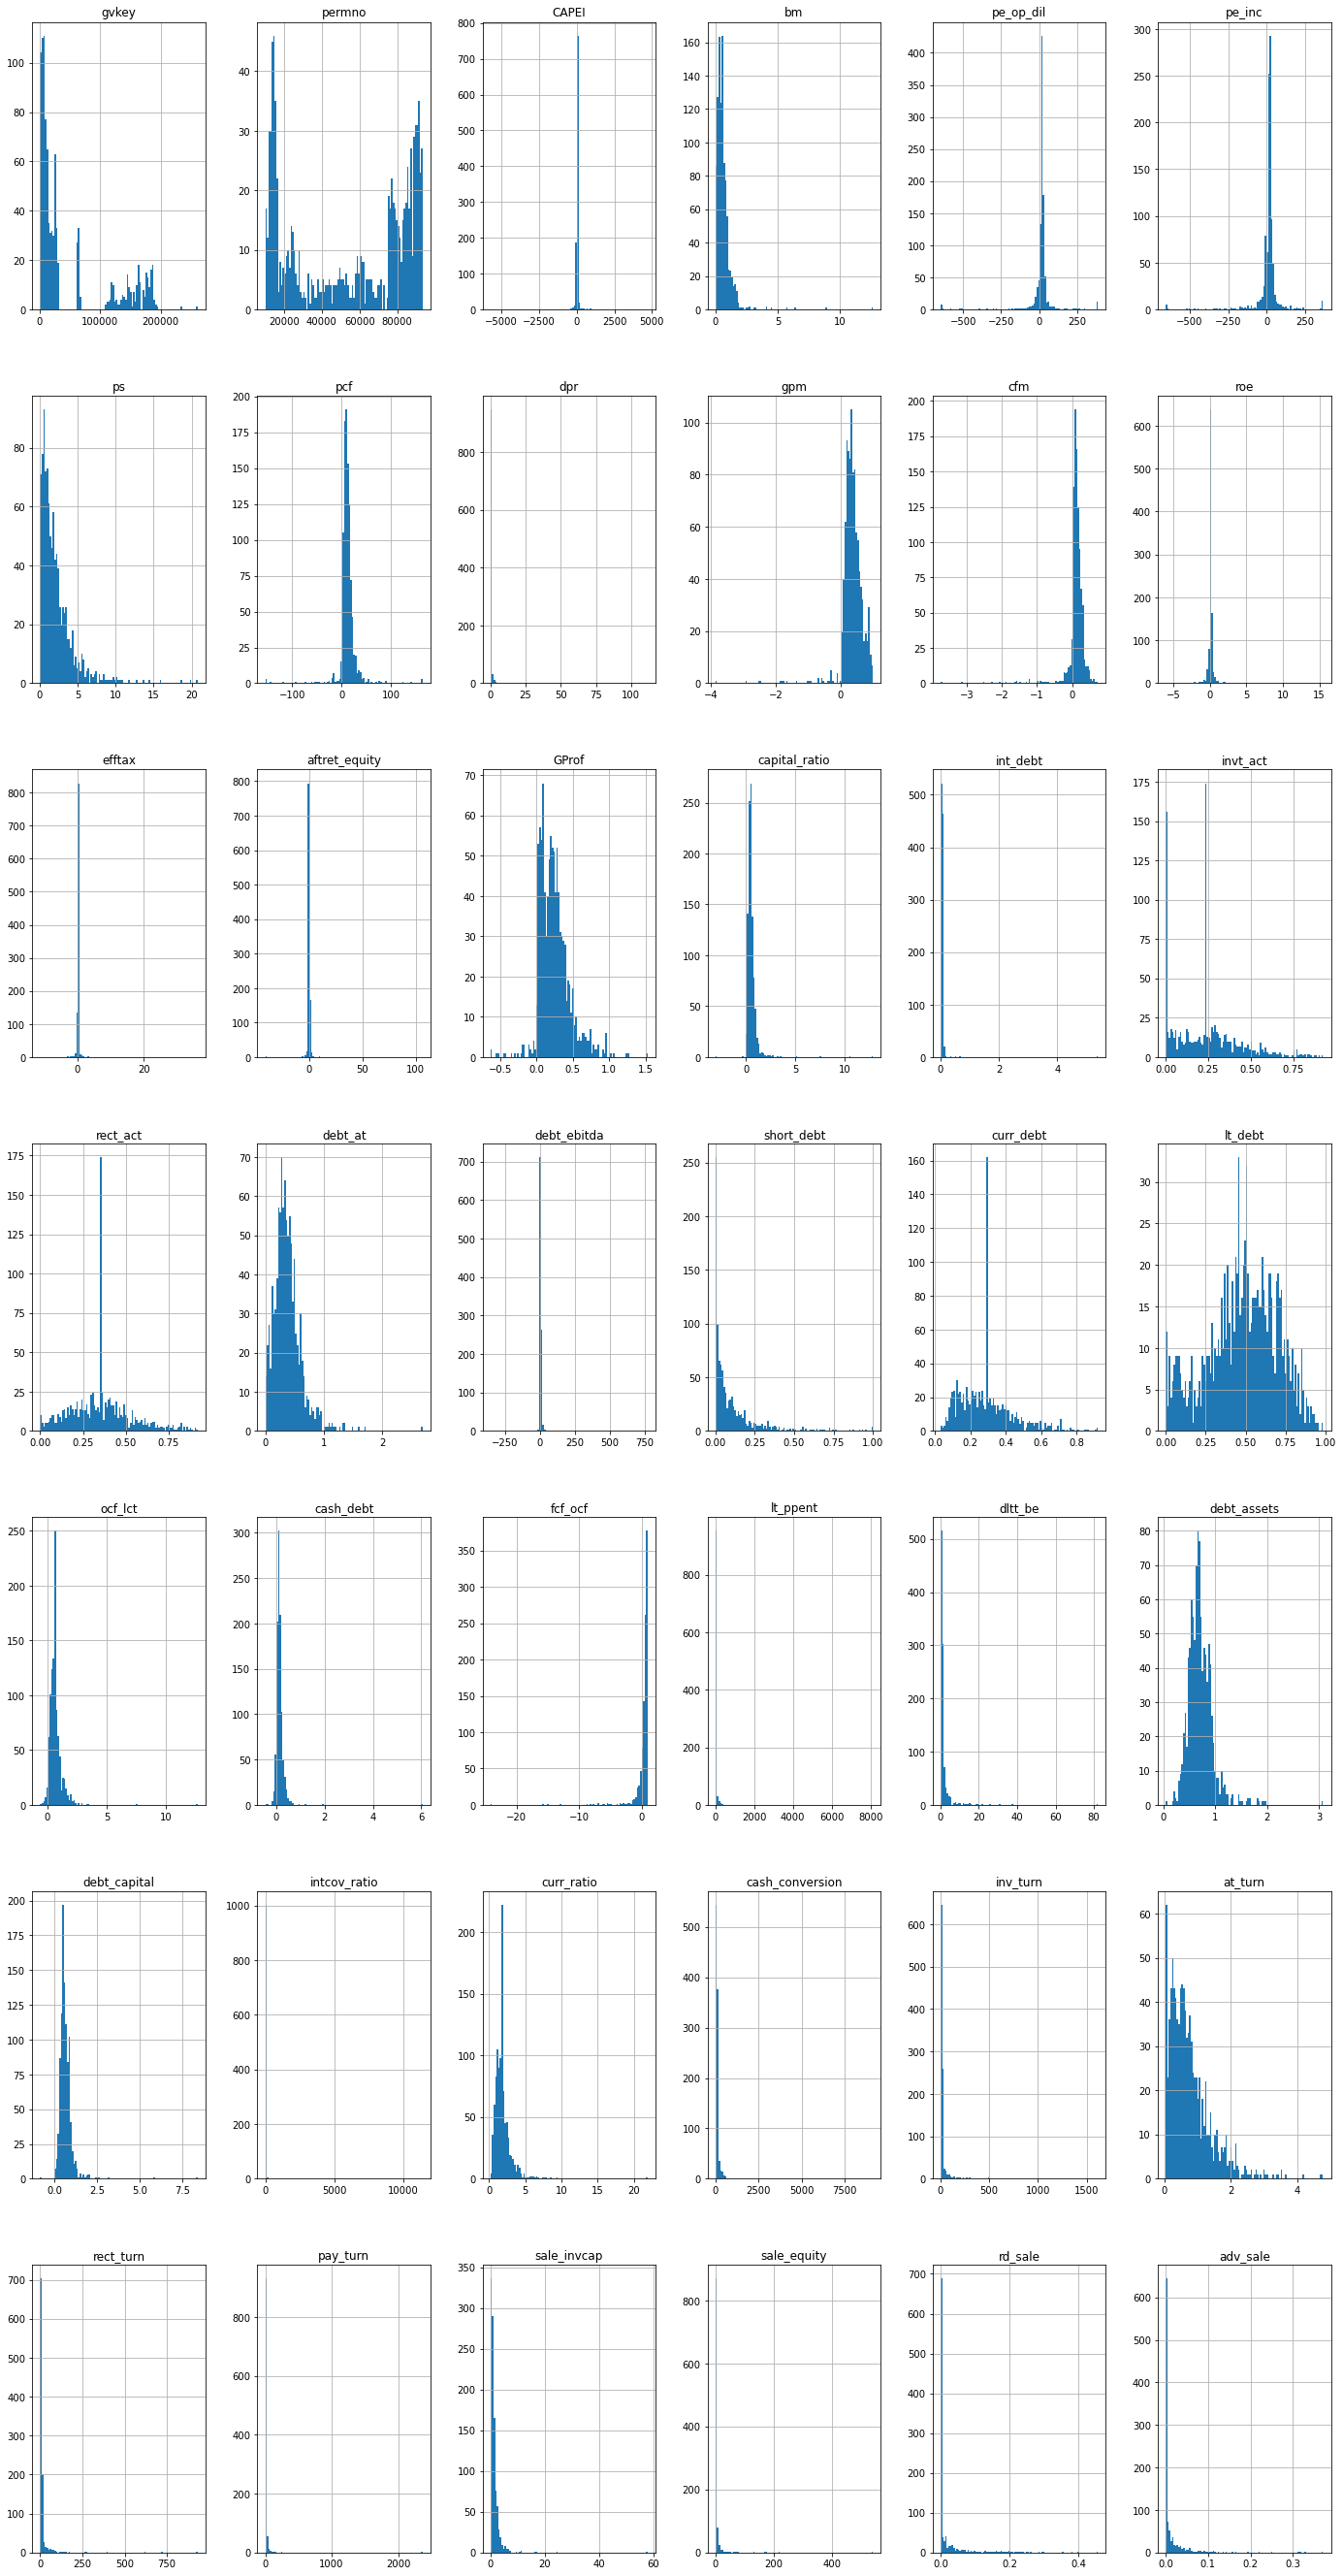

In [43]:
# Visualize features to see distributions and outliers...mostly normal
fig, axes = plt.subplots(len(fin_ratios.columns)//6, 6, figsize=(24, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        fin_ratios.hist(column = fin_ratios.columns[i], bins = 100, ax=axis)
        i = i+1

In [44]:
fin_ratios.drop(['debt_assets',], axis=1, inplace=True)

In [45]:
# Rename columns
cols_to_rename = ['CAPEI', 'bm', 'pe_op_dil', 'pe_inc', 'ps', 'pcf',
       'dpr', 'gpm', 'cfm', 'roe', 'efftax', 'aftret_equity', 'GProf',
       'capital_ratio', 'int_debt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'ocf_lct',
       'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 
       'debt_capital', 'intcov_ratio', 'curr_ratio', 'cash_conversion',
       'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap',
       'sale_equity', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb']


rename_cols = ["Shillers Cyclically Adjusted P/E Ratio", "Book/Market", "Price/Operating Earnings (Diluted, Excl. EI)", "P/E", "Price/Sales",
                "Price/Cash flow", "Dividend Payout Ratio", "Gross Profit Margin", "Cash Flow Margin", "Return on Equity", "Effective Tax Rate", "After-tax Return on Total Stockholders Equity",
                "Gross Profit/Total Assets", "Capitalization Ratio", "Interest/Average Long-term Debt", "Inventory/Current Assets", "Receivables/Current Assets",
                "Total Debt/Total Assets", "Total Debt/EBITDA", "Short-Term Debt/Total Debt", "Current Liabilities/Total Liabilities", "Long-term Debt/Total Liabilities",
                "Operating CF/Current Liabilities", "Cash Flow/Total Debt", "Free Cash Flow/Operating Cash Flow", "Total Liabilities/Total Tangible Assets", "Long-term Debt/Book Equity",
                "Total Debt/Capital", "Interest Coverage Ratio", "Current Ratio", "Cash Conversion Cycle (Days)", "Inventory Turnover", "Asset Turnover",
                "Receivables Turnover", "Payables Turnover", "Sales/Invested Capital", "Sales/Stockholders Equity", "Research and Development/Sales", "Avertising Expenses/Sales", "Labor Expenses/Sales", "Accruals/Average Assets", "Price/Book"

] 

In [46]:
fin_ratios.rename(dict(zip(cols_to_rename, rename_cols)), axis=1, inplace=True)


In [47]:
fin_ratios.columns

Index(['gvkey', 'permno', 'Shillers Cyclically Adjusted P/E Ratio',
       'Book/Market', 'Price/Operating Earnings (Diluted, Excl. EI)', 'P/E',
       'Price/Sales', 'Price/Cash flow', 'Dividend Payout Ratio',
       'Gross Profit Margin', 'Cash Flow Margin', 'Return on Equity',
       'Effective Tax Rate', 'After-tax Return on Total Stockholders Equity',
       'Gross Profit/Total Assets', 'Capitalization Ratio',
       'Interest/Average Long-term Debt', 'Inventory/Current Assets',
       'Receivables/Current Assets', 'Total Debt/Total Assets',
       'Total Debt/EBITDA', 'Short-Term Debt/Total Debt',
       'Current Liabilities/Total Liabilities',
       'Long-term Debt/Total Liabilities', 'Operating CF/Current Liabilities',
       'Cash Flow/Total Debt', 'Free Cash Flow/Operating Cash Flow',
       'Total Liabilities/Total Tangible Assets', 'Long-term Debt/Book Equity',
       'Total Debt/Capital', 'Interest Coverage Ratio', 'Current Ratio',
       'Cash Conversion Cycle (Days)', '

In [48]:
fin_ratios.shape

(1011, 46)

In [49]:
# See big outliers in rows...there are a lot if we run z score of 3 so we do not remove any
from scipy import stats
fin_ratios[(np.abs(stats.zscore(fin_ratios[rename_cols])) < 10).all(axis=1)]

,gvkey,permno,Shillers Cyclically Adjusted P/E Ratio,Book/Market,"Price/Operating Earnings (Diluted, Excl. EI)",P/E,Price/Sales,Price/Cash flow,Dividend Payout Ratio,Gross Profit Margin,...,Payables Turnover,Sales/Invested Capital,Sales/Stockholders Equity,Research and Development/Sales,Avertising Expenses/Sales,Labor Expenses/Sales,Accruals/Average Assets,Price/Book,TICKER,cusip
0,1004,54594,32.067,0.711000,28.563,28.820,0.680,23.465,0.251000,0.172,...,8.074,1.595,1.868000,0.000,0.000,0.000,-0.003,1.219000,AIR,00036110
1,1045,21020,17.273,0.231000,7.069,4.763,0.561,3.665,0.043000,0.371,...,14.239,1.614,8.404000,0.000,0.003,0.261,-0.009,5.112000,AAL,02376R10
2,1075,27991,21.671,0.944000,20.216,20.216,2.473,8.324,0.630000,0.381,...,7.911,0.409,0.750000,0.000,0.000,0.000,-0.040,1.083000,PNW,72348410
3,1078,20482,35.311,0.334000,24.285,45.901,3.472,25.128,1.531000,0.616,...,7.312,0.769,0.993000,0.070,0.000,0.000,-0.046,3.460000,ABT,00282410
4,1161,61241,-20.033,0.060000,-26.590,-15.029,2.351,-154.420,0.846106,0.340,...,3.703,2.448,5.076862,0.236,0.000,0.000,-0.158,25.184000,AMD,00790310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,191255,13085,61.777,0.506000,20.348,20.990,1.312,23.536,0.281000,0.391,...,11.542,1.082,1.890000,0.000,0.001,0.000,0.009,2.332000,VAC,57164Y10
1026,192255,13105,65.359,0.541000,22.179,366.667,1.278,9.292,0.000000,0.320,...,17.295,0.477,1.167000,0.000,0.000,0.543,-0.064,1.432000,ACHC,00404A10
1027,194956,13314,88.185,0.147000,40.416,46.104,2.884,14.707,0.000000,0.453,...,5.135,0.811,3.249000,0.000,0.000,0.000,-0.073,7.739000,VNTV,92210H10
1028,233491,12629,-23.075,0.625386,7.107,6.935,0.456,12.270,0.000000,0.250,...,8.257,4.196,5.076862,0.111,0.000,0.000,0.040,3.764293,MX,55933J20


### Merge fundaments with credit ratings

In [50]:

df = pd.merge(credit_ratings, fin_ratios, how="inner",  on = ['gvkey', "TICKER"])
df.drop(["datadate", "spcsrc"], axis=1, inplace=True)

In [51]:
df

,gvkey,splticrm,conm,TICKER,permno,Shillers Cyclically Adjusted P/E Ratio,Book/Market,"Price/Operating Earnings (Diluted, Excl. EI)",P/E,Price/Sales,...,Receivables Turnover,Payables Turnover,Sales/Invested Capital,Sales/Stockholders Equity,Research and Development/Sales,Avertising Expenses/Sales,Labor Expenses/Sales,Accruals/Average Assets,Price/Book,cusip
0,1004,BB+,AAR CORP,AIR,54594,32.067,0.711000,28.563,28.820,0.680,...,6.410,8.074,1.595,1.868000,0.000,0.000,0.000,-0.003,1.219000,00036110
1,1045,BB-,AMERICAN AIRLINES GROUP INC,AAL,21020,17.273,0.231000,7.069,4.763,0.561,...,25.941,14.239,1.614,8.404000,0.000,0.003,0.261,-0.009,5.112000,02376R10
2,1075,A-,PINNACLE WEST CAPITAL CORP,PNW,27991,21.671,0.944000,20.216,20.216,2.473,...,12.910,7.911,0.409,0.750000,0.000,0.000,0.000,-0.040,1.083000,72348410
3,1078,BBB,ABBOTT LABORATORIES,ABT,20482,35.311,0.334000,24.285,45.901,3.472,...,6.031,7.312,0.769,0.993000,0.070,0.000,0.000,-0.046,3.460000,00282410
4,1161,CCC+,ADVANCED MICRO DEVICES,AMD,61241,-20.033,0.060000,-26.590,-15.029,2.351,...,7.014,3.703,2.448,5.076862,0.236,0.000,0.000,-0.158,25.184000,00790310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,189517,B,ENOVA INTERNATIONAL INC,ENVA,14960,6.577,0.775000,15.495,15.495,0.652,...,1.506,4.795,0.880,3.263000,0.000,0.123,0.000,-0.388,1.878000,29357K10
869,191255,BB+,MARRIOTT VACATIONS WORLDWIDE,VAC,13085,61.777,0.506000,20.348,20.990,1.312,...,1.695,11.542,1.082,1.890000,0.000,0.001,0.000,0.009,2.332000,57164Y10
870,192255,B+,ACADIA HEALTHCARE CO INC,ACHC,13105,65.359,0.541000,22.179,366.667,1.278,...,8.729,17.295,0.477,1.167000,0.000,0.000,0.543,-0.064,1.432000,00404A10
871,233491,CCC+,MAGNACHIP SEMICONDUCTOR CORP,MX,12629,-23.075,0.625386,7.107,6.935,0.456,...,9.730,8.257,4.196,5.076862,0.111,0.000,0.000,0.040,3.764293,55933J20


In [53]:
# Add sectors to data
sectors = pd.read_csv("sectors.csv")[["gvkey","gsector"]]

In [54]:
sectors.head()

,gvkey,gsector
0,1004,20
1,1004,20
2,1004,20
3,1004,20
4,1004,20


In [55]:
sectors.shape

(71445, 2)

In [56]:
sectors = sectors.drop_duplicates()

In [57]:
df = pd.merge(df, sectors, how="left", on="gvkey")

In [58]:
df.shape

(873, 49)

In [59]:
df["gsector"] = df["gsector"].astype("string")

In [60]:
# One Hot encode sectors
one_hot = pd.get_dummies(df["gsector"])

In [61]:
data = pd.concat([df, one_hot], axis=1)

In [62]:
df = data.copy()

In [63]:
df.drop("gsector", axis=1, inplace=True)

In [64]:
df["splticrm"].value_counts()

BBB     125
BB-     105
BBB+    104
BB       86
BBB-     78
BB+      76
B        62
A-       56
A        51
B+       50
B-       24
A+       21
AA-      15
CCC+      6
AA        5
CCC       3
AA+       2
AAA       2
CCC-      1
CC        1
Name: splticrm, dtype: int64

In [65]:
df["splticrm_binned"] = [re.sub('[^A-Z]+', '', _) for _ in df["splticrm"]]


### Encode Target

In [66]:
# 1 is investment grade, 0 is junk
investment_grade = []
df["target"] = [np.nan] * len(df)
df.loc[df['splticrm_binned'].isin(["AAA","AA","A","BBB"]), "target"] = 1
df.loc[~df['splticrm_binned'].isin(["AAA","AA","A","BBB"]), "target"] = 0

In [67]:
df.target.value_counts()

1.0    459
0.0    414
Name: target, dtype: int64

In [68]:
df.drop(["splticrm_binned", "splticrm"], axis=1, inplace=True)

In [69]:
# Feature and target
X = df.drop(["gvkey","conm","TICKER","permno", "target", "cusip"],axis=1)
y = df["target"]

In [70]:
X.isna().sum().any()

False

In [71]:
X.select_dtypes(include="object").any()

Series([], dtype: bool)

In [72]:
#X = X[best_cols]

In [73]:
X

,Shillers Cyclically Adjusted P/E Ratio,Book/Market,"Price/Operating Earnings (Diluted, Excl. EI)",P/E,Price/Sales,Price/Cash flow,Dividend Payout Ratio,Gross Profit Margin,Cash Flow Margin,Return on Equity,...,15,20,25,30,35,40,45,50,55,60
0,32.067,0.711000,28.563,28.820,0.680,23.465,0.251000,0.172,0.071,0.047000,...,0,1,0,0,0,0,0,0,0,0
1,17.273,0.231000,7.069,4.763,0.561,3.665,0.043000,0.371,0.186,1.231000,...,0,1,0,0,0,0,0,0,0,0
2,21.671,0.944000,20.216,20.216,2.473,8.324,0.630000,0.381,0.291,0.057000,...,0,0,0,0,0,0,0,0,1,0
3,35.311,0.334000,24.285,45.901,3.472,25.128,1.531000,0.616,0.116,0.047000,...,0,0,0,0,1,0,0,0,0,0
4,-20.033,0.060000,-26.590,-15.029,2.351,-154.420,0.846106,0.340,-0.101,0.104161,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,6.577,0.775000,15.495,15.495,0.652,1.235,0.000000,0.580,0.073,0.121000,...,0,0,0,0,0,1,0,0,0,0
869,61.777,0.506000,20.348,20.990,1.312,23.536,0.281000,0.391,0.084,0.114000,...,0,0,1,0,0,0,0,0,0,0
870,65.359,0.541000,22.179,366.667,1.278,9.292,0.000000,0.320,0.048,-0.001000,...,0,0,0,0,1,0,0,0,0,0
871,-23.075,0.625386,7.107,6.935,0.456,12.270,0.000000,0.250,0.104,0.104161,...,0,0,0,0,0,0,1,0,0,0


### Univariate Regression

In [75]:
coeff_dict = {}
for i in X.columns:
    model = sm.OLS(y, X[i]).fit()
    coeff_dict[i] = (round(model.params[0],2), round(model.rsquared,2))



In [76]:
# Show coeff and r2
coeff_dict

{'Shillers Cyclically Adjusted P/E Ratio': (0.0, 0.01),
 'Book/Market': (0.35, 0.18),
 'Price/Operating Earnings (Diluted, Excl. EI)': (0.0, 0.03),
 'P/E': (0.0, 0.03),
 'Price/Sales': (0.13, 0.35),
 'Price/Cash flow': (0.01, 0.18),
 'Dividend Payout Ratio': (0.01, 0.01),
 'Gross Profit Margin': (0.99, 0.42),
 'Cash Flow Margin': (1.26, 0.22),
 'Return on Equity': (0.26, 0.06),
 'Effective Tax Rate': (0.07, 0.02),
 'After-tax Return on Total Stockholders Equity': (0.01, 0.0),
 'Gross Profit/Total Assets': (1.27, 0.31),
 'Capitalization Ratio': (0.44, 0.19),
 'Interest/Average Long-term Debt': (0.68, 0.03),
 'Inventory/Current Assets': (1.37, 0.34),
 'Receivables/Current Assets': (1.17, 0.4),
 'Total Debt/Total Assets': (0.83, 0.23),
 'Total Debt/EBITDA': (0.0, 0.01),
 'Short-Term Debt/Total Debt': (2.05, 0.26),
 'Current Liabilities/Total Liabilities': (1.55, 0.51),
 'Long-term Debt/Total Liabilities': (0.74, 0.28),
 'Operating CF/Current Liabilities': (0.44, 0.3),
 'Cash Flow/Total De

In [77]:
# For runnning all combinations of linear regressions for exploration purposes
from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [78]:
# best_coeffs = None
# best_r2 = 0
# best_subset = None
# for subset in powerset(X.columns):
#     if len(subset) > 0:
#         model = sm.OLS(y, X[list(subset)]).fit()
#         if model.rsquared_adj > best_r2:
#             best_r2 = model.rsquared_adj
#             best_coeffs = model.params
#             best_subset = list(subset)

#             print(best_r2, best_coeffs)


In [79]:
#best_subset

In [80]:
#best_r2

In [81]:
#best_coeffs

# Models

In [135]:
def run_lin_reg(X_train_norm, X_test_norm, y_train, y_test):
    model = sm.OLS(y_train, X_train_norm).fit()
    display(model.summary())
    display(model.params[np.where(model.pvalues < 0.05)[0]])

In [136]:
# TP: 1, FN: 1, FP: 2, TN:0
confusion_matrix(y_true=[0,1, 0, 0], y_pred=[0,0,1, 1])

array([[1, 2],
       [1, 0]])

In [137]:
def get_results(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [138]:
def run_log_reg(X_train_norm, X_test_norm, y_train, y_test):
    model = sm.Logit(y_train, X_train_norm).fit()

    display(model.summary())
    
    y_pred = list(map(round, model.predict(X_test_norm)))
    get_results(y_test, y_pred)

    display(model.params[np.where(model.pvalues < 0.05)[0]])

In [139]:
def run_random_forest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    get_results(y_test, y_pred)

    explainer = shap.TreeExplainer(clf)
    shap.plots.beeswarm(explainer(X_test)[:, :, 1], max_display=20)

In [140]:
def run_xgboost(X_train, X_test, y_train, y_test):

    # xgboost
    clf = xgb.XGBClassifier(learning_rate=1.3,n_estimators = 200, max_depth=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    get_results(y_test, y_pred)
    # Feature Importance
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    xgb.plot_importance(booster=clf, ax=ax)
    plt.show()


In [141]:
def normalize(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    return X_train_norm, X_test_norm

In [157]:
def find_best_knn(X_train_norm, X_test_norm, y_train, y_test, K = 50):

    error_rate = []
    # Will take some time
    for i in range(1,K):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train_norm,y_train)
        pred_i = knn.predict(X_test_norm)
        error_rate.append(np.mean(pred_i != y_test))
    plt.figure(figsize=(10,6))
    plt.plot(range(1,K),error_rate)
    plt.show()

In [143]:
def run_knn(X_train_norm, X_test_norm, y_train, y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_norm,y_train)
    y_pred = knn.predict(X_test_norm)

    get_results(y_test, y_pred)

In [160]:
def run_MLP(X_train_norm, X_test_norm, y_train, y_test):
    clf = MLPClassifier().fit(X_train_norm, y_train)
    y_pred = clf.predict(X_test_norm)
    
    get_results(y_test, y_pred)

In [183]:
def run_SVM(X_train_norm, X_test_norm, y_train, y_test):
    clf = SVC().fit(X_train_norm, y_train)
    y_pred = clf.predict(X_test_norm)
    
    get_results(y_test, y_pred)

In [185]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

def run_all_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=9)
    X_train_norm, X_test_norm = normalize(X_train, X_test)
    
    printmd("**------- LINEAR REGRESSION -------**")
    run_lin_reg(X_train_norm, X_test_norm, y_train, y_test)
    printmd("**------- LOG REGRESSION -------**")
    run_log_reg(X_train, X_test, y_train, y_test)
    printmd("**------- RANDOM FOREST -------**")
    run_random_forest(X_train, X_test, y_train, y_test)
    printmd("**------- XGBOOST -------**")
    run_xgboost(X_train, X_test, y_train, y_test)
    printmd("**------- KNN -------**")
    find_best_knn(X_train_norm, X_test_norm, y_train, y_test)
    run_knn(X_train_norm, X_test_norm, y_train, y_test, k=8)
    
    printmd("**------- NETWORK -------**")
    run_MLP(X_train_norm, X_test_norm, y_train, y_test)

    printmd("**------- SVM -------**")
    run_SVM(X_train_norm, X_test_norm, y_train, y_test)


# With All Features

**------- LINEAR REGRESSION -------**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     12.00
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.87e-62
Time:                        22:24:24   Log-Likelihood:                -213.54
No. Observations:                 611   AIC:                             533.1
Df Residuals:                     558   BIC:                             767.1
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Shillers Cyclically Adjusted P/E Ratio            0.1528      0.436      0.351      0.726      -0.703       1.009
Book/Market                                      -0.7355      0.349     -2.109      0.035      -1.420      -0.051
Price/Operating Earnings (Diluted, Excl. EI)     -0.0430      0.198     -0.217      0.828      -0.432       0.346
P/E                                               0.1831      0.194      0.941      0.347      -0.199       0.565
Price/Sales                                       0.0752      0.208      0.362      0.718      -0.333       0.483
Price/Cash flow                                  -0.3280      0.370     -0.886      0.376      -1.055       0.399
Dividend Payout Ratio                            -0.3758      0.255     -1.476      0.141      -0.876       0.124
Gross Profit Margin                               0.2317      0.352      0.658      0.511      -0.460       0.923
Cash Flow Margin                                 -0.0017      0.420     -0.004      0.997      -0.827       0.824
Return on Equity                                 -0.0468      0.359     -0.130      0.896      -0.753       0.659
Effective Tax Rate                                0.7858      0.398      1.972      0.049       0.003       1.568
After-tax Return on Total Stockholders Equity    -0.3452      0.459     -0.753      0.452      -1.246       0.556
Gross Profit/Total Assets                        -0.0795      0.303     -0.262      0.793      -0.674       0.515
Capitalization Ratio                             -1.4446      0.720     -2.005      0.045      -2.860      -0.030
Interest/Average Long-term Debt                  -1.2453      0.164     -7.605      0.000      -1.567      -0.924
Inventory/Current Assets                          0.1420      0.106      1.339      0.181      -0.066       0.350
Receivables/Current Assets                        0.0292      0.104      0.280      0.780      -0.176       0.234
Total Debt/Total Assets                           0.8314      0.420      1.980      0.048       0.007       1.656
Total Debt/EBITDA                                 0.1009      0.575      0.175      0.861      -1.029       1.231
Short-Term Debt/Total Debt                       -0.3552      0.153     -2.329      0.020      -0.655      -0.056
Current Liabilities/Total Liabilities             0.3441      0.181      1.898      0.058      -0.012       0.700
Long-term Debt/Total Liabilities                 -0.9691      0.202     -4.793      0.000      -1.366      -0.572
Operating CF/Current Liabilities                  0.1131      0.213      0.530      0.596      -0.306       0.532
Cash Flow/Total Debt                              0.9276      0.311      2.984      0.003       0.317       1.538
Free 

Book/Market                        -0.735460
Effective Tax Rate                  0.785786
Capitalization Ratio               -1.444574
Interest/Average Long-term Debt    -1.245294
Total Debt/Total Assets             0.831400
Short-Term Debt/Total Debt         -0.355221
Long-term Debt/Total Liabilities   -0.969130
Cash Flow/Total Debt                0.927558
Long-term Debt/Book Equity         -1.050631
Asset Turnover                     -0.927745
Receivables Turnover                0.843780
Accruals/Average Assets             1.112561
Price/Book                          0.814214
dtype: float64

**------- LOG REGRESSION -------**

         Current function value: 0.292562
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  611
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                           52
Date:                Sun, 13 Nov 2022   Pseudo R-squ.:                  0.5773
Time:                        22:24:25   Log-Likelihood:                -178.76
converged:                      False   LL-Null:                       -422.92
Covariance Type:            nonrobust   LLR p-value:                 3.238e-72
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Shillers Cyclically Adjusted P/E Ratio            0.0001      0.000      0.454      0.650      -0.000       0.001
Book/Market                                      -2.2703      0.626     -3.625      0.000      -3.498      -1.043
Price/Operating Earnings (Diluted, Excl. EI)     -0.0012      0.002     -0.592      0.554      -0.005       0.003
P/E                                               0.0042      0.002      1.755      0.079      -0.000       0.009
Price/Sales                                      -0.0740      0.116     -0.636      0.525      -0.302       0.154
Price/Cash flow                                  -0.0285      0.018     -1.599      0.110      -0.064       0.006
Dividend Payout Ratio                            -0.0320      0.015     -2.091      0.037      -0.062      -0.002
Gross Profit Margin                               0.2434      1.451      0.168      0.867      -2.600       3.087
Cash Flow Margin                                  2.8932      1.740      1.663      0.096      -0.517       6.304
Return on Equity                                  0.9424      0.826      1.140      0.254      -0.677       2.562
Effective Tax Rate                                0.5894      0.255      2.310      0.021       0.089       1.089
After-tax Return on Total Stockholders Equity    -0.0605      0.083     -0.727      0.467      -0.224       0.103
Gross Profit/Total Assets                        -1.6703      1.679     -0.995      0.320      -4.962       1.621
Capitalization Ratio                             -1.8583      2.425     -0.766      0.443      -6.610       2.894
Interest/Average Long-term Debt                 -63.5907     10.905     -5.831      0.000     -84.964     -42.218
Inventory/Current Assets                          2.0450      1.117      1.831      0.067      -0.144       4.234
Receivables/Current Assets                        0.1466      1.165      0.126      0.900      -2.136       2.429
Total Debt/Total Assets                           0.8043      3.231      0.249      0.803      -5.527       7.136
Total Debt/EBITDA                                 0.0096      0.022      0.433      0.665      -0.034       0.053
Short-Term Debt/Total Debt                       -2.6298      1.600     -1.644      0.100      -5.766       0.506
Current Liabilities/Total Liabilities             4.2702      2.272      1.880      0.060      -0.182       8.723
Long-term Debt/Total Liabilities                 -5.4519      2.597     -2.099      0.036     -10.543      -0.361
Operating CF/Current Liabilities                  0.1128      0.575      0.196      0.844      -1.014       1.240
Cash Flow/Total Debt                              4.8847      2.238      2.183      0.029       0.499       9.270
Free Cash Flow/Operating Cash Flow                0.4687      0.411      1.140      0.254      -0.337       1.274
Total Liabilities/Total Tangible Assets          

[[ 88  34]
 [ 30 110]]
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73       122
         1.0       0.76      0.79      0.77       140

    accuracy                           0.76       262
   macro avg       0.75      0.75      0.75       262
weighted avg       0.76      0.76      0.76       262



Book/Market                         -2.270333
Dividend Payout Ratio               -0.032017
Effective Tax Rate                   0.589425
Interest/Average Long-term Debt    -63.590668
Long-term Debt/Total Liabilities    -5.451913
Cash Flow/Total Debt                 4.884736
Long-term Debt/Book Equity          -1.031170
Cash Conversion Cycle (Days)         0.001650
Asset Turnover                      -2.454401
Price/Book                           0.186005
10                                   9.066233
15                                   6.969022
20                                   6.339015
25                                   5.922513
30                                   7.585750
35                                   7.112768
40                                   7.440122
45                                   5.412556
50                                   6.274312
55                                  12.214465
dtype: float64

**------- RANDOM FOREST -------**

[[105  17]
 [ 22 118]]
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       122
         1.0       0.87      0.84      0.86       140

    accuracy                           0.85       262
   macro avg       0.85      0.85      0.85       262
weighted avg       0.85      0.85      0.85       262



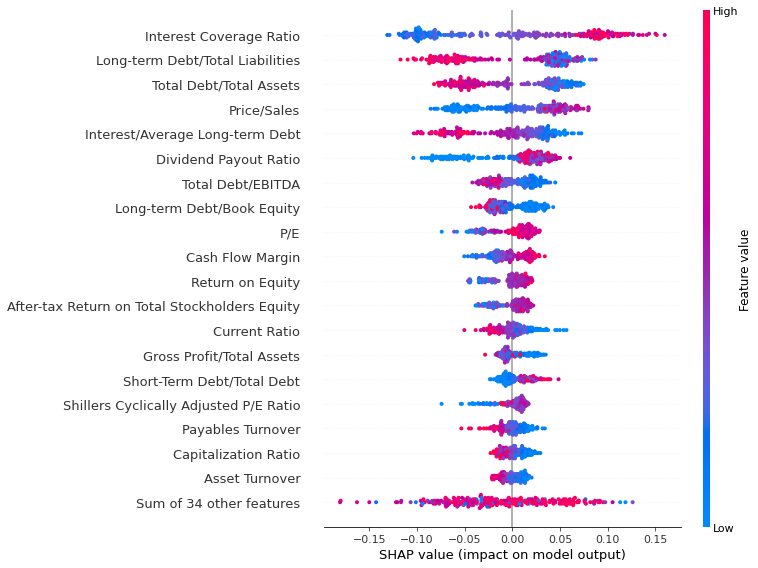

**------- XGBOOST -------**

[[ 99  23]
 [ 26 114]]
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       122
         1.0       0.83      0.81      0.82       140

    accuracy                           0.81       262
   macro avg       0.81      0.81      0.81       262
weighted avg       0.81      0.81      0.81       262



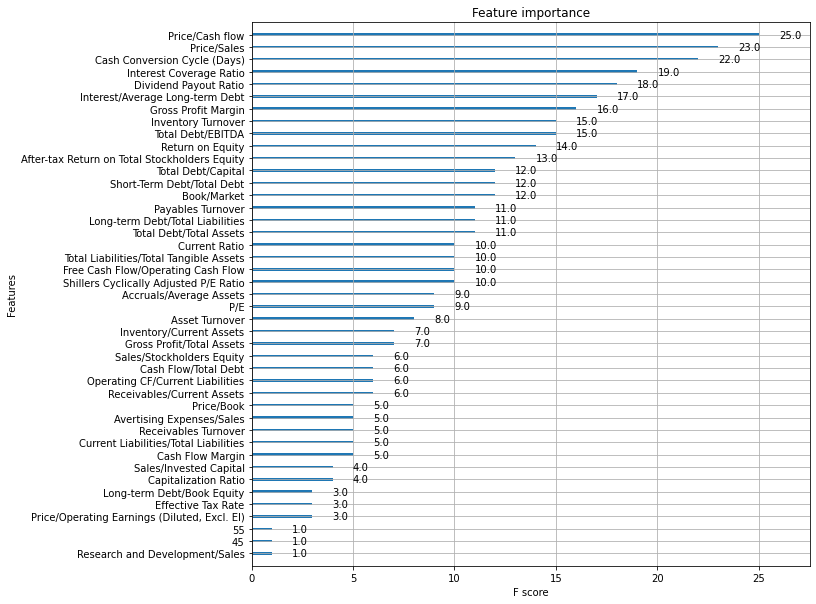

**------- KNN -------**

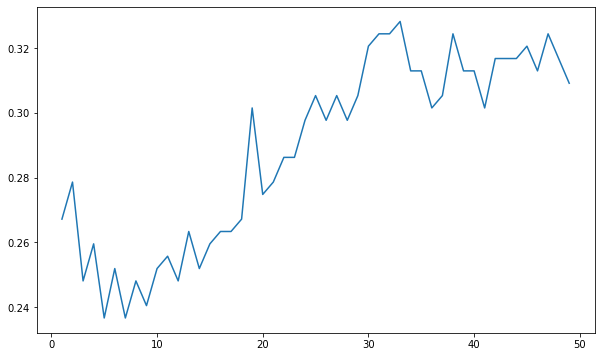

[[ 93  29]
 [ 36 104]]
              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74       122
         1.0       0.78      0.74      0.76       140

    accuracy                           0.75       262
   macro avg       0.75      0.75      0.75       262
weighted avg       0.75      0.75      0.75       262



**------- NETWORK -------**

[[ 89  33]
 [ 22 118]]
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       122
         1.0       0.78      0.84      0.81       140

    accuracy                           0.79       262
   macro avg       0.79      0.79      0.79       262
weighted avg       0.79      0.79      0.79       262



**------- SVM -------**

[[105  17]
 [ 40 100]]
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.79       122
         1.0       0.85      0.71      0.78       140

    accuracy                           0.78       262
   macro avg       0.79      0.79      0.78       262
weighted avg       0.79      0.78      0.78       262



In [186]:
run_all_models(X,y)

# With Subset of Selected Features

In [187]:
keep = ["Interest Coverage Ratio", "Long-term Debt/Total Liabilities", "Gross Profit Margin", "Dividend Payout Ratio", "Asset Turnover", "Interest/Average Long-term Debt", "Total Debt/Total Assets", "Capitalization Ratio", "P/E", "Return on Equity", "Book/Market"]
X_keep = X[keep]

**------- LINEAR REGRESSION -------**

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.704
Model:                            OLS   Adj. R-squared (uncentered):              0.699
Method:                 Least Squares   F-statistic:                              130.0
Date:                Sun, 13 Nov 2022   Prob (F-statistic):                   9.16e-151
Time:                        22:24:39   Log-Likelihood:                         -296.07
No. Observations:                 611   AIC:                                      614.1
Df Residuals:                     600   BIC:                                      662.7
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Interest Coverage Ratio              0.2208      0.293      0.753      0.452      -0.355       0.797
Long-term Debt/Total Liabilities    -0.8690      0.122     -7.110      0.000      -1.109      -0.629
Gross Profit Margin                  0.6526      0.169      3.870      0.000       0.321       0.984
Dividend Payout Ratio               -0.0988      0.275     -0.359      0.720      -0.640       0.442
Asset Turnover                      -0.3506      0.125     -2.810      0.005      -0.596      -0.106
Interest/Average Long-term Debt     -1.2287      0.152     -8.108      0.000      -1.526      -0.931
Total Debt/Total Assets             -0.1553      0.315     -0.493      0.623      -0.774       0.464
Capitalization Ratio                -0.0734      0.333     -0.221      0.825      -0.726       0.580
P/E                                  0.7211      0.166      4.342      0.000       0.395       1.047
Return on Equity                     0.7854      0.257      3.050      0.002       0.280       1.291
Book/Market                         -0.7015      0.299     -2.348      0.019      -1.288      -0.115
==============================================================================
Omnibus:                       54.489   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.935
Skew:                          -0.232   Prob(JB):                     1.73e-05
Kurtosis:                       2.196   Cond. No.                         35.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Long-term Debt/Total Liabilities   -0.868990
Gross Profit Margin                 0.652641
Asset Turnover                     -0.350581
Interest/Average Long-term Debt    -1.228710
P/E                                 0.721088
Return on Equity                    0.785407
Book/Market                        -0.701489
dtype: float64

**------- LOG REGRESSION -------**

Optimization terminated successfully.
         Current function value: 0.516808
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  611
Model:                          Logit   Df Residuals:                      600
Method:                           MLE   Df Model:                           10
Date:                Sun, 13 Nov 2022   Pseudo R-squ.:                  0.2534
Time:                        22:24:39   Log-Likelihood:                -315.77
converged:                       True   LL-Null:                       -422.92
Covariance Type:            nonrobust   LLR p-value:                 1.670e-40
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Interest Coverage Ratio              0.0965      0.020      4.840      0.000       0.057       0.136
Long-term Debt/Total Liabilities    -1.0644      0.816     -1.305      0.192      -2.663       0.534
Gross Profit Margin                  2.3414      0.609      3.848      0.000       1.149       3.534
Dividend Payout Ratio                0.0033      0.014      0.246      0.806      -0.023       0.030
Asset Turnover                      -0.1424      0.172     -0.826      0.409      -0.480       0.195
Interest/Average Long-term Debt     -8.2257      4.727     -1.740      0.082     -17.490       1.038
Total Debt/Total Assets             -3.2579      1.406     -2.317      0.020      -6.014      -0.502
Capitalization Ratio                 0.9973      0.647      1.542      0.123      -0.270       2.265
P/E                                  0.0025      0.001      1.683      0.092      -0.000       0.005
Return on Equity                     0.4094      0.337      1.216      0.224      -0.251       1.069
Book/Market                          0.0031      0.152      0.021      0.983      -0.295       0.301
====================================================================================================
"""

[[102  20]
 [ 46  94]]
              precision    recall  f1-score   support

         0.0       0.69      0.84      0.76       122
         1.0       0.82      0.67      0.74       140

    accuracy                           0.75       262
   macro avg       0.76      0.75      0.75       262
weighted avg       0.76      0.75      0.75       262



Interest Coverage Ratio    0.096466
Gross Profit Margin        2.341438
Total Debt/Total Assets   -3.257861
dtype: float64

**------- RANDOM FOREST -------**

[[101  21]
 [ 23 117]]
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       122
         1.0       0.85      0.84      0.84       140

    accuracy                           0.83       262
   macro avg       0.83      0.83      0.83       262
weighted avg       0.83      0.83      0.83       262



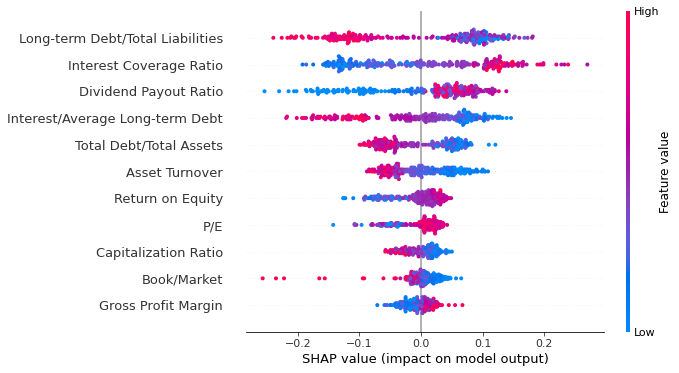

**------- XGBOOST -------**

[[ 97  25]
 [ 24 116]]
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       122
         1.0       0.82      0.83      0.83       140

    accuracy                           0.81       262
   macro avg       0.81      0.81      0.81       262
weighted avg       0.81      0.81      0.81       262



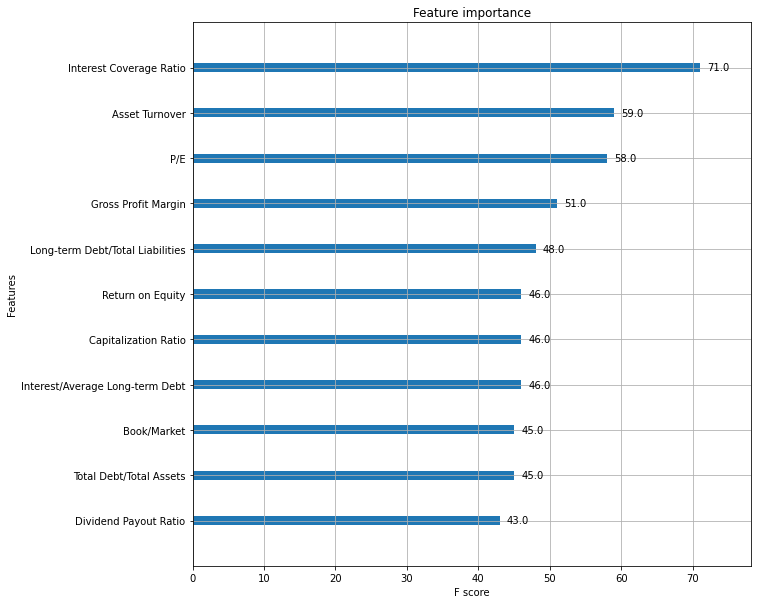

**------- KNN -------**

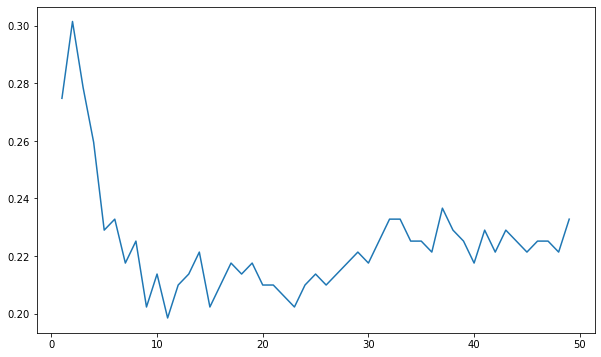

[[ 97  25]
 [ 34 106]]
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       122
         1.0       0.81      0.76      0.78       140

    accuracy                           0.77       262
   macro avg       0.77      0.78      0.77       262
weighted avg       0.78      0.77      0.78       262



**------- NETWORK -------**

[[ 94  28]
 [ 22 118]]
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       122
         1.0       0.81      0.84      0.83       140

    accuracy                           0.81       262
   macro avg       0.81      0.81      0.81       262
weighted avg       0.81      0.81      0.81       262



**------- SVM -------**

[[ 92  30]
 [ 22 118]]
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       122
         1.0       0.80      0.84      0.82       140

    accuracy                           0.80       262
   macro avg       0.80      0.80      0.80       262
weighted avg       0.80      0.80      0.80       262



In [188]:
run_all_models(X_keep, y)